In [376]:
from cryptocmd import CmcScraper
import pandas as pd
import numpy as np
import pylab as p
import matplotlib.pyplot as plot
from collections import Counter
import re
import math

import statsmodels.api as sm
import statsmodels.tsa.api as smt
import statsmodels.formula.api as smf
from statsmodels.tsa.arima.model import ARIMA

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score
from sklearn.ensemble import VotingRegressor
from vecstack import stacking
# from sklearn.metrics import mean_poisson_deviance, mean_gamma_deviance, accuracy_score

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import LSTM
from itertools import cycle
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
from matplotlib import pyplot
import pylab as py
print('All good!')

All good!


In [377]:
scraper_train = CmcScraper("ETH","04-08-2017", "03-08-2022")
train_xrp_json_data = scraper_train.get_data("json")
df_train = scraper_train.get_dataframe()[['Date', 'Close']]
df_train.head()

,Date,Close
0,2022-08-03,1618.874543
1,2022-08-02,1632.945439
2,2022-08-01,1635.195792
3,2022-07-31,1681.517319
4,2022-07-30,1695.969500


In [378]:
df_train.tail()

,Date,Close
1821,2017-08-08,296.769012
1822,2017-08-07,269.179993
1823,2017-08-06,261.566986
1824,2017-08-05,256.506989
1825,2017-08-04,223.072998


C:\Users\OLUWADAMILARE\AppData\Roaming\Python\Python39\site-packages\statsmodels\graphics\gofplots.py:993: UserWarning:

marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.



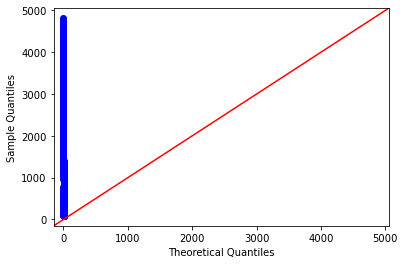

In [379]:
### QQ plot

sm.qqplot(df_train[['Close']], line = '45')
py.show()

In [380]:
df_train.shape

(1826, 2)

Exploratory Analysis

In [381]:
closedf = df_train
close_stock = closedf.copy()

<class 'pandas.core.frame.DataFrame'>


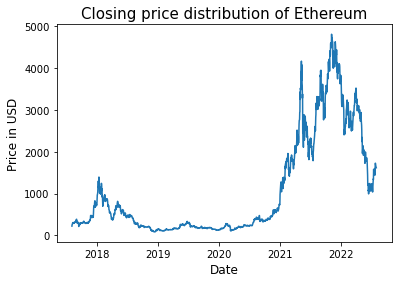

In [382]:
# Time as index

train = df_train.set_index('Date')
train.sort_index(inplace=True)
print(type(train))
train.head

plot.plot(train)
plot.xlabel('Date', fontsize=12)
plot.ylabel('Price in USD', fontsize=12)
plot.title('Closing price distribution of Ethereum', fontsize=15)
plot.show()

Stationary test

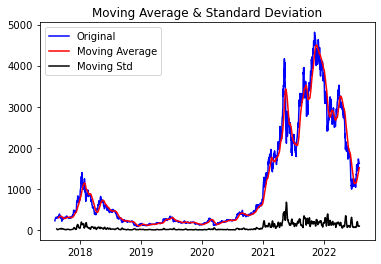

ADF Stastistic: -1.347235
p-value: 0.607295
The graph is non stationery
Critical values:
	1%: -3.434 
	5%: -2.863 
	10%: -2.568 


In [383]:
from statsmodels.tsa.stattools import adfuller

def test_stationarity(x):


    #Determing rolling statistics
    rolmean = x.rolling(window=22,center=False).mean()

    rolstd = x.rolling(window=12,center=False).std()
    
    #Plot rolling statistics:
    orig = plot.plot(x, color='blue',label='Original')
    mean = plot.plot(rolmean, color='red', label='Moving Average')
    std = plot.plot(rolstd, color='black', label = 'Moving Std')
    plot.legend(loc='best')
    plot.title('Moving Average & Standard Deviation')
    plot.show(block=False)
    
    #Perform Dickey Fuller test    
    result=adfuller(x)
    print('ADF Stastistic: %f'%result[0])
    print('p-value: %f'%result[1])
    pvalue=result[1]
    for key,value in result[4].items():
         if result[0]>value:
            print("The graph is non stationery")
            break
         else:
            print("The graph is stationery")
            break;
    print('Critical values:')
    for key,value in result[4].items():
        print('\t%s: %.3f ' % (key, value))
        
ts = train['Close']      
test_stationarity(ts)

Series transformation

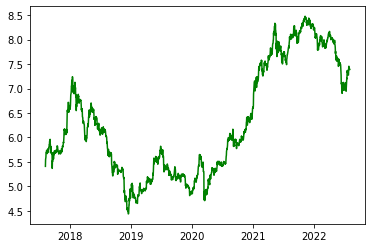

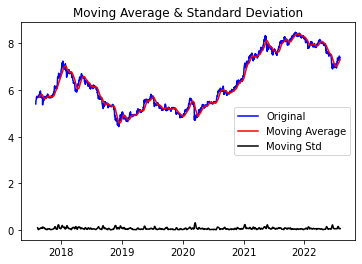

ADF Stastistic: -0.935416
p-value: 0.776086
The graph is non stationery
Critical values:
	1%: -3.434 
	5%: -2.863 
	10%: -2.568 


In [384]:
ts_log = np.log(ts)
plot.plot(ts_log,color="green")
plot.show()

test_stationarity(ts_log)

Differencing the series

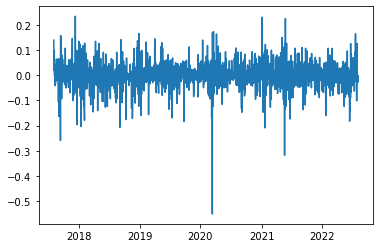

In [385]:
ts_log_diff = ts_log - ts_log.shift()
plot.plot(ts_log_diff)
plot.show()

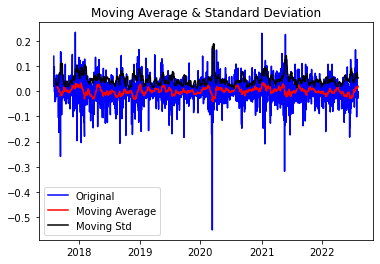

ADF Stastistic: -12.707615
p-value: 0.000000
The graph is stationery
Critical values:
	1%: -3.434 
	5%: -2.863 
	10%: -2.568 


In [386]:
ts_log_diff.dropna(inplace=True)
test_stationarity(ts_log_diff)

C:\Users\OLUWADAMILARE\AppData\Roaming\Python\Python39\site-packages\statsmodels\graphics\gofplots.py:993: UserWarning:

marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.



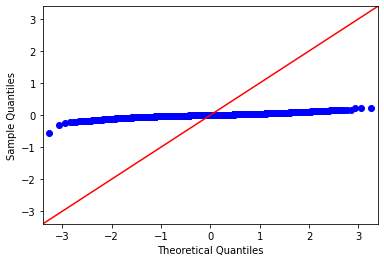

In [387]:
sm.qqplot(ts_log_diff, line = '45')
py.show()

AutoRegressive Integrated Moving Average (ARIMA) model

C:\Users\OLUWADAMILARE\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\OLUWADAMILARE\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\OLUWADAMILARE\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



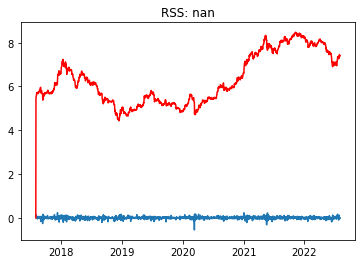

In [388]:
# follow lag
model = ARIMA(ts_log, order=(1,1,0))  
results_ARIMA = model.fit()  
plot.plot(ts_log_diff)
plot.plot(results_ARIMA.fittedvalues, color='red')
plot.title('RSS: %.7f'% sum((results_ARIMA.fittedvalues-ts_log_diff)**2))
plot.show()

C:\Users\OLUWADAMILARE\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\OLUWADAMILARE\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\OLUWADAMILARE\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 1826
Model:                 ARIMA(2, 1, 0)   Log Likelihood                2804.598
Date:                Sat, 20 Aug 2022   AIC                          -5603.196
Time:                        18:51:36   BIC                          -5586.668
Sample:                    08-04-2017   HQIC                         -5597.099
                         - 08-03-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0440      0.018     -2.494      0.013      -0.079      -0.009
ar.L2          0.0600      0.022      2.760      0.006       0.017       0.103
sigma2         0.0027   3.78e-05     71.682      0.0

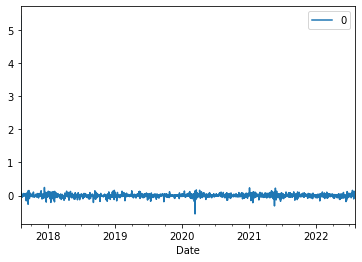

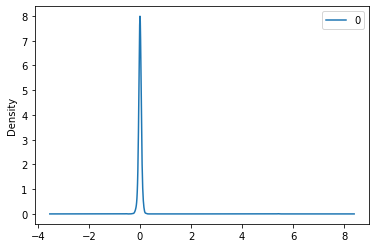

In [389]:
# fit model
model = ARIMA(ts_log, order=(2,1,0))
model_fit = model.fit()
# summary of fit model
print(model_fit.summary())
# line plot of residuals
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
pyplot.show()
# density plot of residuals
residuals.plot(kind='kde')
pyplot.show()


                 0
count  1826.000000
mean      0.004029
std       0.136802
min      -0.551679
25%      -0.021581
50%       0.001493
75%       0.027185
max       5.407499


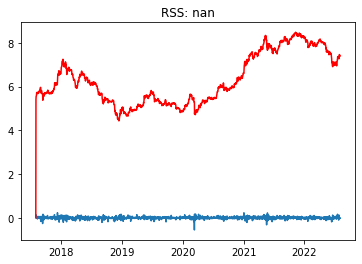

In [390]:
# summary stats of residuals
print(residuals.describe())
plot.plot(ts_log_diff)
plot.plot(model_fit.fittedvalues, color='red')
plot.title('RSS: %.7f'% sum((model_fit.fittedvalues-ts_log_diff)**2))
plot.show()

Model Assessment

Printing Predicted vs Expected Values...


predicted = 1619.505457,   expected = 223.072998,   error = 625.997979  %
predicted = 246.415621,   expected = 256.506989,   error = 3.934149  %


C:\Users\OLUWADAMILARE\AppData\Roaming\Python\Python39\site-packages\statsmodels\base\model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



predicted = 224.151935,   expected = 261.566986,   error = 14.304195  %
predicted = 262.134135,   expected = 269.179993,   error = 2.617526  %
predicted = 268.842062,   expected = 296.769012,   error = 9.410333  %
predicted = 295.244486,   expected = 296.027008,   error = 0.264341  %
predicted = 296.787343,   expected = 295.891998,   error = 0.302592  %
predicted = 295.881796,   expected = 308.864014,   error = 4.203215  %
predicted = 308.066056,   expected = 310.601013,   error = 0.816146  %
predicted = 310.825778,   expected = 298.063995,   error = 4.281558  %
predicted = 298.843072,   expected = 300.096985,   error = 0.417836  %
predicted = 299.672292,   expected = 289.817993,   error = 3.400168  %
predicted = 290.474024,   expected = 302.266998,   error = 3.901509  %
predicted = 301.242991,   expected = 301.457001,   error = 0.070992  %
predicted = 301.818649,   expected = 295.589996,   error = 2.107193  %


C:\Users\OLUWADAMILARE\AppData\Roaming\Python\Python39\site-packages\statsmodels\base\model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



predicted = 295.920688,   expected = 297.470001,   error = 0.520830  %
predicted = 297.212954,   expected = 301.428009,   error = 1.398362  %
predicted = 301.234881,   expected = 321.591003,   error = 6.329817  %
predicted = 320.445412,   expected = 314.785004,   error = 1.798182  %
predicted = 315.692260,   expected = 317.519012,   error = 0.575321  %
predicted = 317.186672,   expected = 325.610992,   error = 2.587235  %
predicted = 325.186415,   expected = 331.915009,   error = 2.027204  %
predicted = 331.736845,   expected = 333.881989,   error = 0.642486  %
predicted = 333.920494,   expected = 347.893005,   error = 4.016324  %
predicted = 347.084481,   expected = 347.747009,   error = 0.190520  %
predicted = 348.108562,   expected = 370.666992,   error = 6.085902  %
predicted = 369.243458,   expected = 378.484985,   error = 2.441716  %
predicted = 378.615912,   expected = 383.041992,   error = 1.155508  %
predicted = 382.968248,   expected = 387.740997,   error = 1.230912  %
predic

C:\Users\OLUWADAMILARE\AppData\Roaming\Python\Python39\site-packages\statsmodels\base\model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



predicted = 289.032523,   expected = 294.532013,   error = 1.867196  %
predicted = 294.039975,   expected = 291.463989,   error = 0.883809  %
predicted = 291.790922,   expected = 277.112000,   error = 5.297108  %
predicted = 277.880875,   expected = 213.908005,   error = 29.906721  %


C:\Users\OLUWADAMILARE\AppData\Roaming\Python\Python39\site-packages\statsmodels\base\model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



predicted = 216.883650,   expected = 250.464005,   error = 13.407258  %
predicted = 246.452644,   expected = 246.522003,   error = 0.028135  %
predicted = 247.701646,   expected = 251.748993,   error = 1.607692  %
predicted = 251.319338,   expected = 293.497009,   error = 14.370733  %
predicted = 290.833495,   expected = 282.803986,   error = 2.839249  %
predicted = 284.507444,   expected = 283.742004,   error = 0.269766  %


C:\Users\OLUWADAMILARE\AppData\Roaming\Python\Python39\site-packages\statsmodels\base\model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



predicted = 283.432228,   expected = 258.579987,   error = 9.611046  %
predicted = 260.123884,   expected = 264.309998,   error = 1.583789  %
predicted = 263.349963,   expected = 286.167999,   error = 7.973651  %
predicted = 284.878296,   expected = 282.483002,   error = 0.847943  %
predicted = 283.237191,   expected = 292.332001,   error = 3.111123  %
predicted = 291.608724,   expected = 287.437988,   error = 1.451004  %


C:\Users\OLUWADAMILARE\AppData\Roaming\Python\Python39\site-packages\statsmodels\base\model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



predicted = 287.978431,   expected = 306.467010,   error = 6.032812  %


C:\Users\OLUWADAMILARE\AppData\Roaming\Python\Python39\site-packages\statsmodels\base\model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



predicted = 305.098235,   expected = 299.154999,   error = 1.986674  %
predicted = 300.074053,   expected = 291.467010,   error = 2.953008  %
predicted = 291.783855,   expected = 301.464996,   error = 3.211365  %
predicted = 300.633375,   expected = 302.337006,   error = 0.563487  %
predicted = 302.521000,   expected = 297.475006,   error = 1.696275  %
predicted = 297.802721,   expected = 292.463013,   error = 1.825772  %
predicted = 292.668625,   expected = 292.657990,   error = 0.003634  %
predicted = 292.529127,   expected = 295.863007,   error = 1.126832  %
predicted = 295.662395,   expected = 308.588013,   error = 4.188632  %


C:\Users\OLUWADAMILARE\AppData\Roaming\Python\Python39\site-packages\statsmodels\base\model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



predicted = 307.840504,   expected = 311.123993,   error = 1.055363  %
predicted = 311.268967,   expected = 308.608002,   error = 0.862248  %
predicted = 308.826491,   expected = 297.391998,   error = 3.844923  %
predicted = 298.036167,   expected = 299.869995,   error = 0.611541  %
predicted = 299.453040,   expected = 303.455994,   error = 1.319122  %
predicted = 303.285265,   expected = 304.135986,   error = 0.279717  %
predicted = 304.176848,   expected = 338.756989,   error = 10.207949  %
predicted = 336.462085,   expected = 339.627991,   error = 0.932169  %
predicted = 340.432160,   expected = 336.595001,   error = 1.139993  %
predicted = 336.806706,   expected = 333.384003,   error = 1.026655  %
predicted = 333.517023,   expected = 317.082001,   error = 5.183209  %
predicted = 318.019449,   expected = 314.319000,   error = 1.177291  %
predicted = 314.124842,   expected = 308.088013,   error = 1.959450  %
predicted = 308.414978,   expected = 304.006012,   error = 1.450289  %
predi

C:\Users\OLUWADAMILARE\AppData\Roaming\Python\Python39\site-packages\statsmodels\base\model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



predicted = 292.528547,   expected = 287.428986,   error = 1.774199  %
predicted = 287.375752,   expected = 305.710999,   error = 5.997575  %
predicted = 304.418147,   expected = 300.468994,   error = 1.314329  %
predicted = 301.227074,   expected = 296.263000,   error = 1.675563  %
predicted = 296.409589,   expected = 298.891998,   error = 0.830537  %
predicted = 298.628224,   expected = 294.658997,   error = 1.347058  %
predicted = 294.985102,   expected = 309.070007,   error = 4.557189  %
predicted = 308.034678,   expected = 320.884003,   error = 4.004352  %
predicted = 320.476071,   expected = 299.252991,   error = 7.092020  %
predicted = 300.836422,   expected = 314.681000,   error = 4.399559  %
predicted = 313.174941,   expected = 307.907990,   error = 1.710560  %
predicted = 308.691591,   expected = 316.716003,   error = 2.533630  %
predicted = 315.986107,   expected = 337.631012,   error = 6.410817  %
predicted = 336.472803,   expected = 333.356995,   error = 0.934676  %
predic

C:\Users\OLUWADAMILARE\AppData\Roaming\Python\Python39\site-packages\statsmodels\base\model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



predicted = 332.244557,   expected = 347.612000,   error = 4.420861  %
predicted = 346.654459,   expected = 354.385986,   error = 2.181669  %


C:\Users\OLUWADAMILARE\AppData\Roaming\Python\Python39\site-packages\statsmodels\base\model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



predicted = 354.310447,   expected = 366.730011,   error = 3.386569  %
predicted = 366.093608,   expected = 360.401001,   error = 1.579520  %
predicted = 361.083680,   expected = 380.652008,   error = 5.140739  %
predicted = 379.173864,   expected = 410.165985,   error = 7.555995  %
predicted = 408.744776,   expected = 474.911011,   error = 13.932344  %


C:\Users\OLUWADAMILARE\AppData\Roaming\Python\Python39\site-packages\statsmodels\base\model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



predicted = 471.474851,   expected = 466.276001,   error = 1.114973  %
predicted = 468.449360,   expected = 471.329987,   error = 0.611170  %
predicted = 470.806864,   expected = 480.355011,   error = 1.987727  %
predicted = 479.914714,   expected = 472.902008,   error = 1.482909  %
predicted = 473.576633,   expected = 427.523010,   error = 10.772197  %
predicted = 430.039297,   expected = 447.114014,   error = 3.818873  %
predicted = 444.803189,   expected = 466.540009,   error = 4.659154  %
predicted = 465.790494,   expected = 463.449005,   error = 0.505231  %
predicted = 464.095386,   expected = 465.852997,   error = 0.377289  %
predicted = 465.631780,   expected = 470.204010,   error = 0.972393  %
predicted = 469.988503,   expected = 463.281006,   error = 1.447825  %
predicted = 463.807816,   expected = 428.588013,   error = 8.217636  %
predicted = 430.515515,   expected = 434.407990,   error = 0.896041  %
predicted = 433.269401,   expected = 456.031006,   error = 4.991241  %
predi

C:\Users\OLUWADAMILARE\AppData\Roaming\Python\Python39\site-packages\statsmodels\base\model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



predicted = 820.243099,   expected = 821.062988,   error = 0.099857  %
predicted = 820.780110,   expected = 674.859985,   error = 21.622281  %
predicted = 682.272219,   expected = 719.387024,   error = 5.159226  %
predicted = 713.613523,   expected = 694.148010,   error = 2.804231  %
predicted = 696.594399,   expected = 765.833984,   error = 9.041070  %
predicted = 760.885162,   expected = 773.835999,   error = 1.673589  %
predicted = 775.197918,   expected = 762.841980,   error = 1.619724  %
predicted = 763.653650,   expected = 737.023010,   error = 3.613271  %
predicted = 738.221172,   expected = 753.591980,   error = 2.039672  %
predicted = 752.023184,   expected = 717.257019,   error = 4.847100  %
predicted = 719.669609,   expected = 756.732971,   error = 4.897812  %
predicted = 753.511769,   expected = 772.640991,   error = 2.475823  %
predicted = 772.704794,   expected = 884.443970,   error = 12.633833  %
predicted = 878.111922,   expected = 962.719971,   error = 8.788438  %
pred

C:\Users\OLUWADAMILARE\AppData\Roaming\Python\Python39\site-packages\statsmodels\base\model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



predicted = 1159.184615,   expected = 1273.199951,   error = 8.955022  %
predicted = 1263.604760,   expected = 1396.420044,   error = 9.511127  %


C:\Users\OLUWADAMILARE\AppData\Roaming\Python\Python39\site-packages\statsmodels\base\model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



predicted = 1392.759340,   expected = 1366.770020,   error = 1.901514  %
predicted = 1371.468197,   expected = 1291.920044,   error = 6.157359  %
predicted = 1295.235005,   expected = 1053.689941,   error = 22.923733  %
predicted = 1063.699830,   expected = 1014.250000,   error = 4.875507  %
predicted = 1011.140431,   expected = 1036.280029,   error = 2.425946  %
predicted = 1034.166507,   expected = 1039.099976,   error = 0.474783  %
predicted = 1039.492369,   expected = 1155.150024,   error = 10.012349  %
predicted = 1148.880732,   expected = 1049.579956,   error = 9.461002  %


C:\Users\OLUWADAMILARE\AppData\Roaming\Python\Python39\site-packages\statsmodels\base\model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



predicted = 1057.665074,   expected = 1003.260010,   error = 5.422828  %
predicted = 1003.363255,   expected = 986.229004,   error = 1.737350  %


C:\Users\OLUWADAMILARE\AppData\Roaming\Python\Python39\site-packages\statsmodels\base\model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



predicted = 986.051492,   expected = 1058.780029,   error = 6.869089  %
predicted = 1054.404330,   expected = 1056.030029,   error = 0.153944  %
predicted = 1057.938646,   expected = 1055.170044,   error = 0.262384  %
predicted = 1055.150859,   expected = 1107.069946,   error = 4.689775  %
predicted = 1104.252979,   expected = 1246.010010,   error = 11.376877  %
predicted = 1239.775548,   expected = 1182.359985,   error = 4.856014  %


C:\Users\OLUWADAMILARE\AppData\Roaming\Python\Python39\site-packages\statsmodels\base\model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



predicted = 1188.883846,   expected = 1071.130005,   error = 10.993422  %


C:\Users\OLUWADAMILARE\AppData\Roaming\Python\Python39\site-packages\statsmodels\base\model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



predicted = 1075.428528,   expected = 1118.310059,   error = 3.834494  %
predicted = 1113.414325,   expected = 1036.790039,   error = 7.390531  %
predicted = 1041.948870,   expected = 915.784973,   error = 13.776585  %
predicted = 920.172417,   expected = 964.018982,   error = 4.548309  %
predicted = 958.895572,   expected = 834.682007,   error = 14.881543  %
predicted = 842.107266,   expected = 697.950989,   error = 20.654212  %
predicted = 701.971488,   expected = 793.122009,   error = 11.492623  %
predicted = 784.972335,   expected = 757.067993,   error = 3.685844  %
predicted = 760.965211,   expected = 817.807007,   error = 6.950515  %


C:\Users\OLUWADAMILARE\AppData\Roaming\Python\Python39\site-packages\statsmodels\base\model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



predicted = 813.604850,   expected = 883.864990,   error = 7.949194  %
predicted = 881.701989,   expected = 860.414978,   error = 2.474040  %


C:\Users\OLUWADAMILARE\AppData\Roaming\Python\Python39\site-packages\statsmodels\base\model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



predicted = 863.064666,   expected = 814.659973,   error = 5.941705  %


C:\Users\OLUWADAMILARE\AppData\Roaming\Python\Python39\site-packages\statsmodels\base\model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



predicted = 816.565159,   expected = 868.706970,   error = 6.002232  %
predicted = 864.767800,   expected = 845.257996,   error = 2.308148  %
predicted = 847.617775,   expected = 923.560974,   error = 8.222868  %
predicted = 918.639773,   expected = 936.976013,   error = 1.956959  %
predicted = 938.012265,   expected = 944.210022,   error = 0.656396  %
predicted = 944.110819,   expected = 974.114990,   error = 3.080147  %


C:\Users\OLUWADAMILARE\AppData\Roaming\Python\Python39\site-packages\statsmodels\base\model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



predicted = 972.650943,   expected = 923.921021,   error = 5.274252  %
predicted = 927.163202,   expected = 943.864990,   error = 1.769510  %
predicted = 941.718602,   expected = 895.370972,   error = 5.176361  %
predicted = 898.335045,   expected = 849.971008,   error = 5.690081  %
predicted = 851.377309,   expected = 812.844971,   error = 4.740429  %
predicted = 813.857008,   expected = 864.189026,   error = 5.824191  %


C:\Users\OLUWADAMILARE\AppData\Roaming\Python\Python39\site-packages\statsmodels\base\model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



predicted = 860.532536,   expected = 840.515015,   error = 2.381578  %
predicted = 842.882433,   expected = 844.809998,   error = 0.228165  %
predicted = 844.072992,   expected = 869.315002,   error = 2.903667  %
predicted = 868.074643,   expected = 878.265015,   error = 1.160284  %
predicted = 878.320868,   expected = 855.198975,   error = 2.703686  %
predicted = 856.610944,   expected = 872.200012,   error = 1.787327  %
predicted = 870.780614,   expected = 856.853027,   error = 1.625435  %
predicted = 858.034608,   expected = 857.224976,   error = 0.094448  %
predicted = 856.878724,   expected = 866.677979,   error = 1.130668  %


C:\Users\OLUWADAMILARE\AppData\Roaming\Python\Python39\site-packages\statsmodels\base\model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



predicted = 866.174374,   expected = 853.684021,   error = 1.463112  %
predicted = 854.579645,   expected = 816.950989,   error = 4.605987  %


C:\Users\OLUWADAMILARE\AppData\Roaming\Python\Python39\site-packages\statsmodels\base\model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



predicted = 818.621743,   expected = 752.830994,   error = 8.739113  %
predicted = 755.405102,   expected = 704.596008,   error = 7.211096  %
predicted = 705.790868,   expected = 728.916016,   error = 3.172539  %
predicted = 726.567716,   expected = 686.890015,   error = 5.776427  %
predicted = 689.575875,   expected = 723.338989,   error = 4.667675  %
predicted = 720.392249,   expected = 699.830994,   error = 2.938032  %
predicted = 701.884030,   expected = 690.827026,   error = 1.600546  %
predicted = 690.797084,   expected = 614.291016,   error = 12.454369  %
predicted = 617.969377,   expected = 611.304016,   error = 1.090351  %
predicted = 609.828327,   expected = 601.666016,   error = 1.356618  %
predicted = 602.107345,   expected = 552.778992,   error = 8.923703  %
predicted = 555.065326,   expected = 538.643982,   error = 3.048645  %
predicted = 538.324975,   expected = 556.726013,   error = 3.305223  %
predicted = 555.427777,   expected = 557.174988,   error = 0.313584  %
predi

C:\Users\OLUWADAMILARE\AppData\Roaming\Python\Python39\site-packages\statsmodels\base\model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



predicted = 540.945168,   expected = 539.619019,   error = 0.245757  %
predicted = 539.131810,   expected = 526.439026,   error = 2.411064  %
predicted = 527.125619,   expected = 524.286987,   error = 0.541427  %
predicted = 524.103691,   expected = 489.950989,   error = 6.970636  %
predicted = 491.659614,   expected = 450.115997,   error = 9.229536  %
predicted = 451.399785,   expected = 446.278992,   error = 1.147442  %
predicted = 445.597604,   expected = 385.967987,   error = 15.449369  %
predicted = 388.797022,   expected = 394.644989,   error = 1.481830  %
predicted = 392.779768,   expected = 396.457001,   error = 0.927524  %
predicted = 396.578625,   expected = 379.606995,   error = 4.470842  %
predicted = 380.508163,   expected = 386.424988,   error = 1.531170  %
predicted = 385.657867,   expected = 416.893005,   error = 7.492363  %
predicted = 415.429864,   expected = 380.542999,   error = 9.167654  %
predicted = 383.069547,   expected = 383.231995,   error = 0.042389  %
predi

C:\Users\OLUWADAMILARE\AppData\Roaming\Python\Python39\site-packages\statsmodels\base\model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



predicted = 501.015858,   expected = 531.702026,   error = 5.771309  %
predicted = 530.329033,   expected = 511.147003,   error = 3.752742  %
predicted = 512.943484,   expected = 502.894012,   error = 1.998328  %
predicted = 502.826608,   expected = 524.789001,   error = 4.184995  %
predicted = 523.418295,   expected = 567.888977,   error = 7.830876  %
predicted = 566.172559,   expected = 615.718018,   error = 8.046777  %
predicted = 614.402957,   expected = 605.395020,   error = 1.487944  %
predicted = 607.132783,   expected = 621.859985,   error = 2.368251  %
predicted = 620.747481,   expected = 642.547974,   error = 3.392819  %
predicted = 641.909083,   expected = 708.158020,   error = 9.355106  %
predicted = 705.274612,   expected = 615.416016,   error = 14.601277  %
predicted = 621.416759,   expected = 662.809021,   error = 6.244976  %
predicted = 657.860880,   expected = 647.031982,   error = 1.673626  %
predicted = 649.093489,   expected = 683.677979,   error = 5.058593  %
predi

C:\Users\OLUWADAMILARE\AppData\Roaming\Python\Python39\site-packages\statsmodels\base\model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



predicted = 433.360857,   expected = 436.085999,   error = 0.624909  %
predicted = 436.086261,   expected = 449.850006,   error = 3.059630  %
predicted = 449.159966,   expected = 480.657990,   error = 6.553105  %
predicted = 479.376165,   expected = 501.002014,   error = 4.316519  %
predicted = 500.831803,   expected = 480.513000,   error = 4.228565  %
predicted = 482.137597,   expected = 469.618988,   error = 2.665695  %
predicted = 469.649441,   expected = 450.697998,   error = 4.204910  %
predicted = 451.393869,   expected = 462.436005,   error = 2.387819  %
predicted = 461.277278,   expected = 459.657013,   error = 0.352494  %
predicted = 460.132975,   expected = 450.852997,   error = 2.058316  %
predicted = 451.241275,   expected = 479.372986,   error = 5.868439  %
predicted = 477.552910,   expected = 472.493011,   error = 1.070894  %
predicted = 473.661770,   expected = 464.036987,   error = 2.074141  %
predicted = 464.299128,   expected = 469.665985,   error = 1.142696  %

 Mean

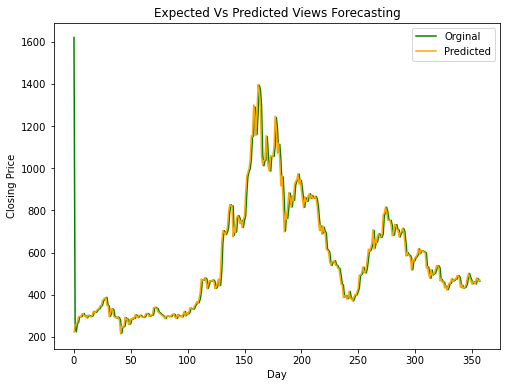

In [391]:
size = int(len(ts_log)-358)
# Divide into train and test
train_arima, test_arima = ts_log[358:len(ts_log)], ts_log[0:358]
history = [x for x in train_arima]
predictions = list()
originals = list()
error_list = list()

print('Printing Predicted vs Expected Values...')
print('\n')
# We go over each value in the test set and then apply ARIMA model and calculate the predicted value. We have the expected value in the test set therefore we calculate the error between predicted and expected value 
for t in range(len(test_arima)):
    model = ARIMA(history, order=(2, 1, 0))
    model_fit = model.fit()
    
    output = model_fit.forecast()
    
    pred_value = output[0]
    
        
    original_value = test_arima[t]
    history.append(original_value)
    
    pred_value = np.exp(pred_value)
    
    
    original_value = np.exp(original_value)
    
    # Calculating the error
    error = ((abs(pred_value - original_value)) / original_value) * 100
    error_list.append(error)
    print('predicted = %f,   expected = %f,   error = %f ' % (pred_value, original_value, error), '%')
    
    predictions.append(float(pred_value))
    originals.append(float(original_value))
    
# After iterating over whole test set the overall mean error is calculated.   
print('\n Mean Error in Predicting Test Case Articles : %f ' % (sum(error_list)/float(len(error_list))), '%')
plot.figure(figsize=(8, 6))
test_day = [t
           for t in range(len(test_arima))]
labels={'Orginal','Predicted'}
plot.plot(test_day, predictions, color= 'green')
plot.plot(test_day, originals, color = 'orange')
plot.title('Expected Vs Predicted Views Forecasting')
plot.xlabel('Day')
plot.ylabel('Closing Price')
plot.legend(labels)
plot.show()

Long-Short Term Memory Artificial Neural Network  (LSTM-ANN)

In [396]:
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100 
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

In [397]:
# closedf_ = closedf['Date']
del closedf['Date']
scaler=MinMaxScaler(feature_range=(0,1))
closedf=scaler.fit_transform(np.array(closedf).reshape(-1,1))
print(closedf.shape)

ValueError: cannot delete array elements

In [398]:
training_size=int(len(closedf)*.8)
test_size=len(closedf)-training_size
train_data,test_data=closedf[0:training_size,:],closedf[training_size:len(closedf),:1]
print("train_data: ", train_data.shape)
print("test_data: ", test_data.shape)

print(test_data[-1])

train_data:  (1460, 1)
test_data:  (366, 1)
[0.02935093]


In [399]:
time_step = 7
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

print("X_train: ", X_train.shape)
print("y_train: ", y_train.shape)
print("X_test: ", X_test.shape)
print("y_test", y_test.shape)
print(y_test [-1])

X_train:  (1452, 7)
y_train:  (1452,)
X_test:  (358, 7)
y_test (358,)
0.0364227433277555


In [400]:
# reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

print("X_train: ", X_train.shape)
print("X_test: ", X_test.shape)

X_train:  (1452, 7, 1)
X_test:  (358, 7, 1)


In [401]:
model=Sequential()

model.add(LSTM(10,input_shape=(None,1),activation="relu"))

model.add(Dense(1))

model.compile(loss="mean_squared_error",optimizer="adam")

In [402]:
history = model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=200,batch_size=50,verbose=1)

Epoch 1/200
30/30 [==============================] - 2s 17ms/step - loss: 0.1638 - val_loss: 0.0033
Epoch 2/200
30/30 [==============================] - 0s 5ms/step - loss: 0.0839 - val_loss: 3.4798e-04
Epoch 3/200
30/30 [==============================] - 0s 5ms/step - loss: 0.0363 - val_loss: 2.3552e-04
Epoch 4/200
30/30 [==============================] - 0s 5ms/step - loss: 0.0103 - val_loss: 1.6902e-04
Epoch 5/200
30/30 [==============================] - 0s 5ms/step - loss: 0.0018 - val_loss: 1.5859e-04
Epoch 6/200
30/30 [==============================] - 0s 5ms/step - loss: 6.6625e-04 - val_loss: 1.8596e-04
Epoch 7/200
30/30 [==============================] - 0s 6ms/step - loss: 5.7306e-04 - val_loss: 1.7402e-04
Epoch 8/200
30/30 [==============================] - 0s 5ms/step - loss: 5.5575e-04 - val_loss: 1.9515e-04
Epoch 9/200
30/30 [==============================] - 0s 5ms/step - loss: 5.4615e-04 - val_loss: 1.5517e-04
Epoch 10/200
30/30 [==============================] - 0s 5ms

30/30 [==============================] - 0s 5ms/step - loss: 4.1252e-04 - val_loss: 1.2106e-04
Epoch 78/200
30/30 [==============================] - 0s 4ms/step - loss: 4.0728e-04 - val_loss: 1.2251e-04
Epoch 79/200
30/30 [==============================] - 0s 4ms/step - loss: 4.4040e-04 - val_loss: 1.5650e-04
Epoch 80/200
30/30 [==============================] - 0s 4ms/step - loss: 4.3601e-04 - val_loss: 1.4203e-04
Epoch 81/200
30/30 [==============================] - 0s 4ms/step - loss: 4.2115e-04 - val_loss: 1.4432e-04
Epoch 82/200
30/30 [==============================] - 0s 5ms/step - loss: 4.0340e-04 - val_loss: 1.2133e-04
Epoch 83/200
30/30 [==============================] - 0s 5ms/step - loss: 4.0730e-04 - val_loss: 1.1871e-04
Epoch 84/200
30/30 [==============================] - 0s 4ms/step - loss: 4.0477e-04 - val_loss: 1.1872e-04
Epoch 85/200
30/30 [==============================] - 0s 4ms/step - loss: 4.0465e-04 - val_loss: 1.1735e-04
Epoch 86/200
30/30 [=====================

30/30 [==============================] - 0s 5ms/step - loss: 3.6876e-04 - val_loss: 9.9728e-05
Epoch 153/200
30/30 [==============================] - 0s 6ms/step - loss: 3.7820e-04 - val_loss: 9.9455e-05
Epoch 154/200
30/30 [==============================] - 0s 6ms/step - loss: 3.6521e-04 - val_loss: 9.9828e-05
Epoch 155/200
30/30 [==============================] - 0s 7ms/step - loss: 3.6616e-04 - val_loss: 1.0364e-04
Epoch 156/200
30/30 [==============================] - 0s 7ms/step - loss: 3.6094e-04 - val_loss: 9.8968e-05
Epoch 157/200
30/30 [==============================] - 0s 6ms/step - loss: 3.6339e-04 - val_loss: 9.8799e-05
Epoch 158/200
30/30 [==============================] - 0s 6ms/step - loss: 3.7579e-04 - val_loss: 1.0408e-04
Epoch 159/200
30/30 [==============================] - 0s 6ms/step - loss: 3.8487e-04 - val_loss: 9.7719e-05
Epoch 160/200
30/30 [==============================] - 0s 5ms/step - loss: 3.6325e-04 - val_loss: 1.0421e-04
Epoch 161/200
30/30 [============

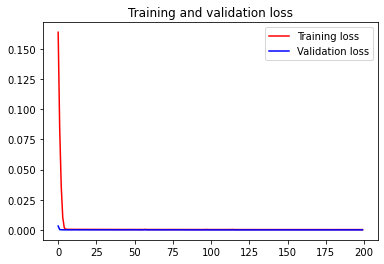

<Figure size 432x288 with 0 Axes>

In [403]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plot.plot(epochs, loss, 'r', label='Training loss')
plot.plot(epochs, val_loss, 'b', label='Validation loss')
plot.title('Training and validation loss')
plot.legend(loc=0)
plot.figure()


plot.show()

In [404]:
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)
train_predict.shape, test_predict.shape

12/12 [==============================] - 0s 3ms/step


((1452, 1), (358, 1))

In [405]:
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
original_ytrain = scaler.inverse_transform(y_train.reshape(-1,1)) 
original_ytest = scaler.inverse_transform(y_test.reshape(-1,1)) 

In [406]:
print("Train data RMSE: ", math.sqrt(mean_squared_error(original_ytrain,train_predict)))
print("Train data MSE: ", mean_squared_error(original_ytrain,train_predict))
print("Train data MAE: ", mean_absolute_error(original_ytrain,train_predict))
print("-------------------------------------------------------------------------------------")
print("Test data RMSE: ", math.sqrt(mean_squared_error(original_ytest,test_predict)))
print("Test data MSE: ", mean_squared_error(original_ytest,test_predict))
print("Test data MAE: ", mean_absolute_error(original_ytest,test_predict))

Train data RMSE:  90.06550470485747
Train data MSE:  8111.7951377407035
Train data MAE:  53.07759694215129
-------------------------------------------------------------------------------------
Test data RMSE:  51.82625161724969
Test data MSE:  2685.9603566944756
Test data MAE:  37.96586634460108


In [407]:
print("Train data explained variance regression score:", 
      explained_variance_score(original_ytrain, train_predict))
print("Test data explained variance regression score:", 
      explained_variance_score(original_ytest, test_predict))

Train data explained variance regression score: 0.9956267158746676
Test data explained variance regression score: 0.9680945938385899


In [408]:
print("Train data R2 score:", r2_score(original_ytrain, train_predict))
print("Test data R2 score:", r2_score(original_ytest, test_predict))

Train data R2 score: 0.9953764414461717
Test data R2 score: 0.9580067501963413


In [409]:
# close_stock = X_train
# closedf=scaler.fit_transform(np.array(closedf).reshape(-1,1))
# close_stock.head

In [410]:
# close_stock[['Date']]
close_stock

,Date,Close
0,2022-08-03,1618.874543
1,2022-08-02,1632.945439
2,2022-08-01,1635.195792
3,2022-07-31,1681.517319
4,2022-07-30,1695.969500
...,...,...
1821,2017-08-08,296.769012
1822,2017-08-07,269.179993
1823,2017-08-06,261.566986
1824,2017-08-05,256.506989


In [411]:

look_back = 7
trainPredictPlot = np.empty_like(closedf)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
print("Train predicted data: ", trainPredictPlot.shape)

# shift test predictions for plotting
testPredictPlot = np.empty_like(closedf)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(closedf)-1, :] = test_predict
print("Test predicted data: ", testPredictPlot.shape)

names = cycle(['Original close price','Train predicted close price','Test predicted close price'])


plotdf = pd.DataFrame({'date': close_stock['Date'],
                       'original_close': close_stock['Close'],
                      'train_predicted_close': trainPredictPlot.reshape(1,-1)[0].tolist(),
                      'test_predicted_close': testPredictPlot.reshape(1,-1)[0].tolist()})

fig = px.line(plotdf,x=plotdf['date'], y=[plotdf['original_close'],plotdf['train_predicted_close'],
                                          plotdf['test_predicted_close']],
              labels={'value':'Stock price','date': 'Date'})
fig.update_layout(title_text='Comparision between original close price vs predicted close price',
                  plot_bgcolor='white', font_size=15, font_color='black', legend_title_text='Close Price')
fig.for_each_trace(lambda t:  t.update(name = next(names)))

fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

Train predicted data:  (1826, 1)
Test predicted data:  (1826, 1)


Essemble Model

In [ ]:
model_1 = model_fit
model_2 = history

ensembling = VotingRegressor(

    estimators = [
        ('ARIMA', model_1),
        ('LSTM', model_2)],
    weights = [.5, .5]
)

In [ ]:
# ensemble_fit = ensembling.fit(X_train, y_train)

Arima_predicted_test = predictions
lstm_predicted_test = test_predict

print(len(Arima_predicted_test), len(lstm_predicted_test))

In [ ]:
history = [x for x in test_data]
# model = ARIMA(history, order=(2, 1, 0))
# model_fit_ = model.fit()
predictions_ = list()
originals = list()
error_list = list()

# print('Printing Predicted vs Expected Values...')
# print('\n')
# We go over each value in the test set and then apply ARIMA model and calculate the predicted value. We have the expected value in the test set therefore we calculate the error between predicted and expected value 
for t in range(len(test_data)):
    model = ARIMA(history, order=(2, 1, 0))
    model_fit = model.fit()
    
    output = model_fit.forecast()
    
    pred_value = output[0]
    
        
    original_value = test_data[t]
    history.append(original_value)
    
    pred_value = np.exp(pred_value)
    
    
    original_value = np.exp(original_value)
    
    # Calculating the error
    error = ((abs(pred_value - original_value)) / original_value) * 100
    error_list.append(error)
#     print('predicted = %f,   expected = %f,   error = %f ' % (pred_value, original_value, error), '%')
    
    predictions_.append(float(pred_value))
    originals.append(float(original_value))

# main_arima = model_fit_.forecast()
# print(r2_score(test_data, main_arima))
print(len(predictions_))

In [ ]:
print(type(test_data))

In [ ]:
# history = [x for x in test_data]
# model = ARIMA(history, order=(2, 1, 0))
# model_fit_ = model.fit()
main_arima = predictions_

def CustomBlender(original_ytest, main_arima, lstm_predicted_test):
    arima_r2 = r2_score(original_ytest, main_arima)
    lstm_r2 = r2_score(original_ytest, lstm_predicted_test)
    
    arima_Weigth = arima_r2 / (arima_r2 + lstm_r2)
    lstm_Weigth = lstm_r2 / (arima_r2 + lstm_r2)
    
    blendedPred = []
    
    for i in range(len(main_arima)):
        blendedPred_ = (arima_Weigth * main_arima[i]) + (lstm_Weigth * lstm_predicted_test[i])
        blendedPred.append(blendedPred_)
        
    blendedPred_r2 = r2_score(original_ytest, blendedPred)
    
    return blendedPred, blendedPred_r2

the_blended, blend_r2 = CustomBlender(original_ytest, main_arima, lstm_predicted_test)

print(blend_r2)
print(the_blended.head)

In [ ]:
arima_r2 = r2_score(original_ytest, Arima_predicted_test)
lstm_r2 = r2_score(original_ytest, lstm_predicted_test)

sum_ = arima_r2 + lstm_r2

arima_Weigth = arima_r2/sum_
lstm_Weigth = lstm_r2/sum_

print(arima_r2, lstm_r2)

In [ ]:
len(test_predict)

In [ ]:
df_train

hybrid_data = df_train[['Close']][0:200]
print(type(hybrid_data))
hybrid_data.head

In [ ]:
hybrid_data_ = pd.DataFrame.to_numpy(hybrid_data)
hybrid_data_ = np.ndarray.tolist(hybrid_data_)
type(hybrid_data_)
print(hybrid_data_[7])

In [ ]:
history = [x for x in train_arima]
predictions_ = list()
originals = list()
error_list = list()
real_data_array = np.asarray(hybrid_data_)

# hybrid_data_ = pd.DataFrame.to_numpy(hybrid_data)

for t in range(len(real_data_array)):
    model = ARIMA(history, order=(2, 1, 0))
    model_fit = model.fit()
    
    output = model_fit.forecast()
    
    pred_value = output[0]
    
        
    original_value = real_data_array[t]
    history.append(original_value)
    
    pred_value = np.exp(pred_value)
    
    
    original_value = np.exp(original_value)
    
    # Calculating the error
    error = ((abs(pred_value - original_value)) / original_value) * 100
    error_list.append(error)
#     print('predicted = %f,   expected = %f,   error = %f ' % (pred_value, original_value, error), '%')
    
    predictions_.append(float(pred_value))
#     originals.append(float(original_value)

In [ ]:
print(predictions_)

In [ ]:

arima_array = np.asarray(predictions_)

arima_r2 = r2_score(real_data_array, arima_array)
print(arima_r2)